In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import astropy.units as u
from astropy.coordinates import SkyCoord

from tqdm import tqdm
from tqdm import trange

import pandas as pd

## Parameters

In [2]:
Rearth  =  6371000.0  # Radius of Earth (m)
Rneo    =  7155780.0  # NEOSSat semi-major axis 
neoincl = 98.61       # NEOSSat orbit inclination
iearth_deg = 23.44    # Inclination of the earth (deg)
earthlimbex = 2       # Earth-limb exclusion angle (changed)
sunexclude=45.0       # Sun exclusion angle (deg)
sunsensorlimit = 45   # Minimum angle from the sun 
bdn = 0               # Number of Brown Dwarfs
nra = 300             # Number of samples in RA
ndec = 300            # Number of samples in DEC

## Import List of Targets from File
#### Below, use either Sexagimal or Degree to input targets based on which coordinate system you are working with. Comment out the other or just don't run it.

### Sexagimal

In [ ]:
bd_ra = []  # arrays to hold ra and dec
bd_dec = []
bd_ra_deg = []
bd_dec_deg = []

# Files used here (ex.'BrownDwarfSexa.txt') are included in the One Drive folder
with open('BrownDwarfsSexa.txt', 'r') as f:
    for line in f:
        rows = line.strip()
        rows = line.split(",")
        
        #convert to decimals and then radians
        if rows[0][0]!='#':
            ra1 = float(rows[0])+np.float(rows[1])/60+np.float(rows[2])/3600
            ra1_rad = ra1/12*np.pi
            dec1 = float(rows[3])+np.float(rows[4])/60+np.float(rows[5])/3600
            dec1_rad = dec1/180*np.pi
            
            #append to list
            bd_ra.append(ra1_rad)
            bd_dec.append(dec1_rad)
            bd_ra_deg.append(ra1)
            bd_dec_deg.append(dec1)
            bdn += 1
            
bd_matrix = [bd_ra, bd_dec]

### Degree

In [4]:
bd_ra = []  # arrays to hold ra and dec
bd_dec = []
bd_ra_deg = []
bd_dec_deg = []

# Files used here (ex.'UCDCandidatesDeg.txt') are included in the Google Drive folder
with open('/Users/Joelene/Desktop/UCDCandidatesDeg.txt', 'r') as f:
    for line in f:
        rows = line.strip()
        rows = line.split(",")
        
        # converts to float and to radians
        ra1 = float(rows[0])
        ra1_rad = ra1/180*np.pi
        dec1 = float(rows[1])
        dec1_rad = dec1/180*np.pi
        
        #append to list
        bd_ra.append(ra1_rad)
        bd_dec.append(dec1_rad)
        bd_ra_deg.append(ra1*24/360)
        bd_dec_deg.append(dec1)
        bdn += 1
        
bd_matrix = [bd_ra, bd_dec]

## Constants

In [5]:
ineo_deg  =neoincl-90.0  #inclination of NEOSSat orbit  
ineo_rad  =(neoincl-90.0)/180.0*np.pi #unit conversion deg->rad
sunexclude_rad = sunexclude/180*np.pi #unit conversion deg->rad
sunsensorlimit_rad = sunsensorlimit/180*np.pi # unit conversion

alpha=np.arcsin(Rearth/Rneo)+earthlimbex/180.0*np.pi #angular size of Earth from satellite.

dcvz_rad=np.pi/2-alpha #width of CVZ
dcvz_deg=dcvz_rad/np.pi*180.0 #rad -> deg

bd_ra_rad = np.linspace(0, 2*np.pi, bdn) #gid of RA for targets
ra_rad=np.linspace(0,2*np.pi,nra) #grid of RA to scan
dec_rad=np.linspace(-np.pi/2,np.pi/2,ndec) #grid of DEC to scan

continuous_days = np.zeros((bdn)) #array to hold the total continuous days of object
continuousapprox = np.zeros((bdn)) #array of cartesian approx
cvz_region = np.zeros((bdn)) #array to hold objects with continuous viewing (within CVZ)
vismap=np.zeros((nra,ndec)) #array to hold yearly visibility map
vismap_day=np.zeros((nra,ndec)) #array to hold daily visibility map
vismapapprox = np.zeros((nra, ndec)) #array of cartesian approx

dcvz_p=dcvz_rad+ineo_rad #northern edge of CVZ
dcvz_m=-dcvz_rad+ineo_rad #southern edge of CVZ

adr=1.0/np.sin(alpha) #ratio of semi-major axis to Earth+limb radius 

#fraction of yearly orbit when Earth blocks CVZ (0.5 is approx. to account for changing impact parameter)
forbit=2*np.arcsin(1/adr)/(np.pi)*0.5 

rfrac=alpha/(np.pi) #max fraction of orbit blocked by Earth

## Sun Distance Function

In [6]:
# calculates the distance from an object to the sun and the number of days visible
def sunDistanceTime(theRange, ra_rad, objectRa, objectDec):
    iearth_rad = iearth_deg/180*np.pi # inclination of the earth in radians
    tvis = 0 
    
    for i in range(theRange):
        # ra and dec of the sun
        ra = ra_rad[i]
        dec = iearth_rad*np.sin(ra)
        
        #distance between Sun and target
        dsun=np.arccos(np.sin(objectDec)*np.sin(dec)+np.cos(objectDec)*np.cos(dec)*np.cos(objectRa-ra))
        
        #check that the object is opposite to the sun and within the sun sensor limit
        if np.pi - sunsensorlimit_rad < dsun < np.pi + sunsensorlimit_rad: 
            tvis+=1
    return tvis      

## For Background

In [7]:
for i in trange(nra): #scan over ra (change to range if you don't want tqdm monitoring)
    for j in range(ndec): #scan over dec

        rang=np.abs(ineo_rad-dec_rad[j]) #angle relative to satellite 
        b=np.abs(adr*np.cos(rang)) #impact parameter of Earth-limb occultation
        
        if b<1:
            vismap_day[i,j]=1-rfrac*np.sqrt(1-np.power(adr*np.cos(rang),2)) #occultation 
        else:
            vismap_day[i,j]=1.0 #no occultation, target always visible
            
        tvis = sunDistanceTime(nra, ra_rad, ra_rad[i], dec_rad[j])
        
        #creates an array with the time visible for each point
        vismap[i,j]=vismap_day[i,j]*tvis*365.25/nra*(1-forbit)

100%|██████████| 300/300 [03:09<00:00,  1.59it/s]


## Calculate Visibility of Targets

In [9]:
# Initialize indices
index = -1 #used to index the matrix of RA and DEC values

count_visible = 0 #number of objects visible to the satelite
count_not_visible = 0 #number of objects with a visibility of 0 days
count_cvz = 0 #number of objects in satelite's CVZ

star_list = [] #holds list of lists for each stars' data

for ra in tqdm(bd_matrix[0]): #scan over ra with tqdm monitoring
    index += 1
    dec_match = bd_matrix[1][index] # declination of the object
    
    rang = np.abs(ineo_rad- dec_match) #angle relative to satellite 
    b = np.abs(adr*np.cos(rang)) #impact parameter of Earth-limb occultation
    
    tvis = sunDistanceTime(bdn, bd_ra_rad, ra, dec_match) #calculate visibility time
    tvis_days = 365.25*tvis/bdn*(1-forbit) #time visible in days
    
    if tvis_days > 0: #target visible to satelite
        count_visible += 1
    
        if b<1: #occultation, target visible but partially
            CVZ = "False"
            
        else: #no occultation, in CVZ (target always visible)
            count_cvz += 1
            CVZ = "True"
    
    else: #target not visible to satelite
        count_not_visible += 1
        CVZ = "False"
            
    each_star = [ra * 180/np.pi, dec_match * 180/np.pi, tvis_days, CVZ] #information for each star, convert rad to deg
    star_list.append(each_star) #list of information for all stars
    
#create pandas dataframe to hold info for all stars
col_names = ["RA (deg)", "DEC (deg)", "Visibility (days)", "CVZ"]
visibility_df = pd.DataFrame(star_list, columns=col_names)

visibility_df #show truncated table

100%|██████████| 3726/3726 [01:33<00:00, 40.04it/s]


,RA (deg),DEC (deg),Visibility (days),CVZ
0,47.291138,2.268599,55.780825,True
1,48.435164,4.554607,56.658277,True
2,43.804737,7.379722,57.285027,True
3,52.116320,8.219686,57.911778,True
4,49.234796,6.284136,57.222352,True
...,...,...,...,...
3721,309.184532,-8.787228,57.974453,True
3722,310.575972,-8.359579,57.786428,True
3723,312.907460,-3.511195,56.282226,True
3724,314.475390,-2.875069,56.031526,True


### Write table to file:

In [ ]:
visibility_df.to_csv("Visibility Table.txt")

## Object Counts

In [10]:
#print object counts
print("\033[1m Total objects: \033[0m {}".format(bdn))
print(" \033[1m Observable: \033[0m {0} ({1}% of total objects)".format(count_visible, (str(round(float(count_visible / bdn * 100), 2)))))
print(" \033[1m Observable, in CVZ: \033[0m {0} ({1}% of total objects, {2}% of observable objects)".format(count_cvz, str(round(float(count_cvz / bdn * 100), 2)), str(round(float(count_cvz / count_visible * 100), 2))))
print(" \033[1m Not observable: \033[0m {0} ({1}% of total objects)".format(count_not_visible, str(round(float(count_not_visible / bdn * 100), 2))))                                                            

 Total objects:  3726
  Observable:  2645 (70.99% of total objects)
  Observable, in CVZ:  1478 (39.67% of total objects, 55.88% of observable objects)
  Not observable:  1081 (29.01% of total objects)


## Visibility Plot

In [12]:
#for plotting: define ordered lists of ra, dec, and visibility time from pandas dataframe, convert units
ra_list_deg = visibility_df[col_names[0]].values / 15 #degrees to radians
dec_list_deg = visibility_df[col_names[1]].values
vis_time_list = visibility_df[col_names[2]].values

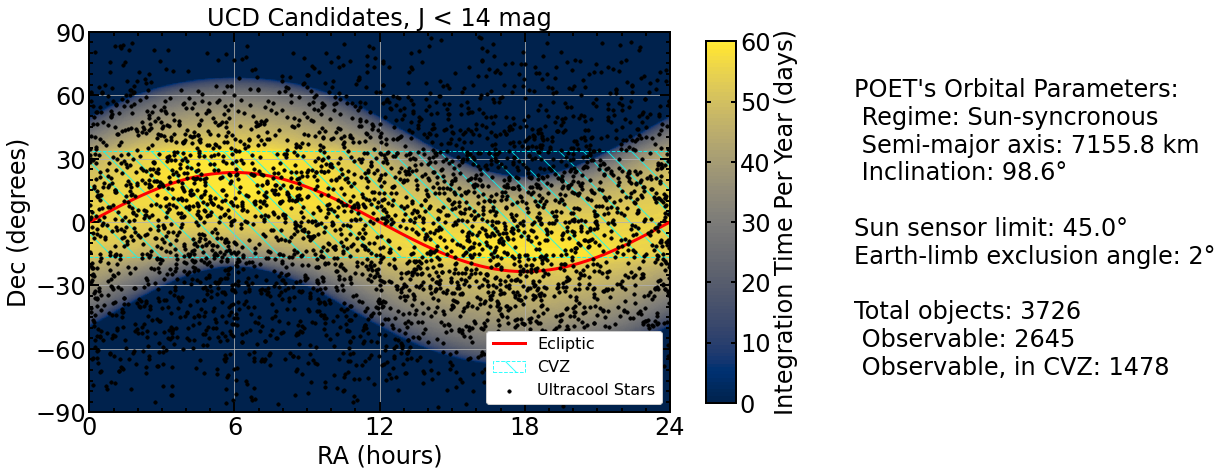

In [18]:
#set up plot
matplotlib.rcParams.update({'font.size': 24}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(18,7)) #adjust size of figure
ax = plt.axes()

#add stars
#plt.scatter(ra_list_deg, dec_list_deg, c= vis_time_list, marker='*',s=90,zorder=4, label='Ultracool Stars', cmap = cmap, edgecolors= "black", linewidths=0.5) #for color stars
#plt.scatter(ra_list_deg, dec_list_deg, c= "#000000",marker='*',s=50,zorder=4, label='Ultracool Stars', cmap = 'cividis', edgecolors= "black", linewidths=0.5) #for black stars
plt.scatter(ra_list_deg, dec_list_deg, c= "#000000",marker='.',s=50,zorder=4, label='Ultracool Stars', cmap = 'cividis', edgecolors= "black", linewidths=0.5) #above, small black dots

#add ecliptic
ax.plot(ra_rad/(2*np.pi)*24,iearth_deg*np.sin(ra_rad),zorder=2,color='red',lw=3,label='Ecliptic')

#add CVZ
ax.fill([0, 24, 24, 0], \
        [-dcvz_deg+ineo_deg, -dcvz_deg+ineo_deg, dcvz_deg+ineo_deg, dcvz_deg+ineo_deg],\
        fill=False, hatch='\\',color='cyan',ls='--',label='CVZ',alpha=0.8)

#add plot ticks and labels, set limits
ax.tick_params(direction='in', length=10, width=2,bottom=True, top=True, left=True, right=True)
ax.tick_params(which='minor', direction='in',length=4, width=2,bottom=True, top=True, left=True, right=True)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(6))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))

ax.grid(axis='both')

ax.set_xlabel('RA (hours)')
ax.set_ylabel('Dec (degrees)')
plt.title("UCD Candidates, J < 14 mag", fontsize=24)

ax.set_xlim(0,24)
ax.set_ylim(-90,90)

#add background and colour bar
cmap = plt.get_cmap('cividis')
levels = MaxNLocator(nbins=100).tick_values(0,60)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.imshow(vismap.T,extent=[0,24,-90,90],aspect="auto",origin='lower',
          cmap=cmap,norm=norm)
cbar=fig.colorbar(im, ax=ax, aspect=12, ticks=[0,10,20,30,40,50,60], shrink=0.95)
cbar.set_label('Integration Time Per Year (days)')
cbar.ax.tick_params(direction='in', length=5, width=2,left=True, right=True)

#add legend
ax.legend(fontsize=16,loc='lower right',framealpha=1.0)


#add sidetext (comment these lines out if unwanted)
side_text_CVZ = "POET's Orbital Parameters: \n Regime: Sun-syncronous \n Semi-major axis: {} km\n Inclination: {}\N{DEGREE SIGN} \n \nSun sensor limit: {}\N{DEGREE SIGN} \nEarth-limb exclusion angle: {}\N{DEGREE SIGN} \n \nTotal objects: {} \n Observable: {} \n Observable, in CVZ: {}".format(
                    Rneo / 1000, neoincl, sunsensorlimit, earthlimbex, bdn, count_visible, count_cvz)

plt.gcf().text(0.68, 0.2, side_text_CVZ, fontsize=24)
plt.subplots_adjust(left = 0.09, right=0.65)

#save figure
plt.savefig("UCD Candidates Visibility Plot, Jmag < 14.pdf")

### Density Plot (Useful for large samples)

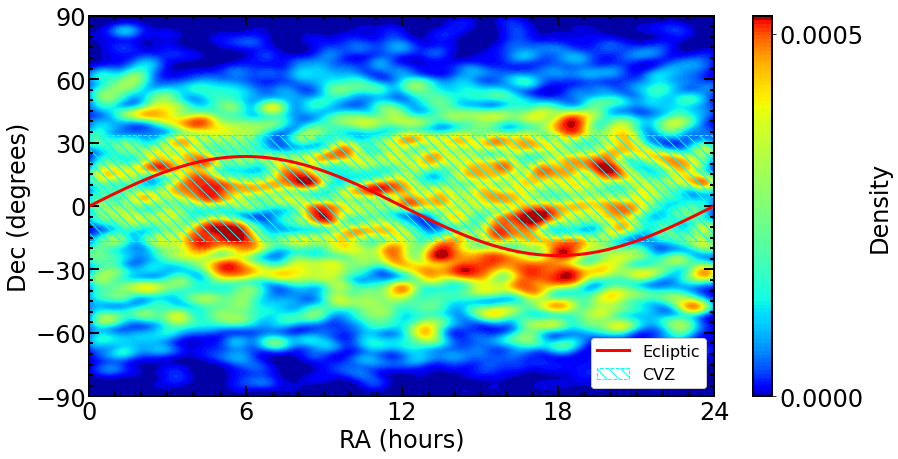

In [14]:
## Set up plot
matplotlib.rcParams.update({'font.size': 24}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
f, ax = plt.subplots(figsize=(14, 7)) # Define size

## Add ecliptic and CVZ
ax.plot(ra_rad/(2*np.pi)*24,iearth_deg*np.sin(ra_rad),zorder=2,color='red',lw=3,label='Ecliptic')

ax.fill([0, 24, 24, 0], \
        [-dcvz_deg+ineo_deg, -dcvz_deg+ineo_deg, dcvz_deg+ineo_deg, dcvz_deg+ineo_deg],\
        fill=False, hatch = "\\\\", color ='cyan',ls='--',label='CVZ',alpha=1)


## Define axis labels and limits, add tik marks
ax.tick_params(direction='in', length=10, width=2,bottom=True, top=True, left=True, right=True)
ax.tick_params(which='minor', direction='in',length=4, width=2,bottom=True, top=True, left=True, right=True)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(6))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))

ax.set_xlim(0,24)
ax.set_ylim(-90,90)
ax.set_xlabel('RA (hours)')
ax.set_ylabel('Dec (degrees)')

## Plot graph
sns.kdeplot(x=ra_list_deg, y=dec_list_deg, cmap=plt.cm.jet, fill=True, cbar=True, cbar_kws={'label': 'Density', 'ticks': [0, 0.0005, 0.001, 0.0015, 0.002]}, thresh=0, bw_adjust=0.25, levels=100)
ax.legend(fontsize=16,loc='lower right',framealpha=1.0) # add legend
#plt.savefig("Density Plot.pdf") # save figure